## __Desafío - Expansiones basales__

## Ejercicio 1: Preparar el ambiente de trabajo
<ul>
<li>Importe los módulos clásicos del trabajo en ciencia de datos.</li>
<li>El archivo tiene el nombre <code>compresive_strength_concrete.csv</code>. Importe y genere
estadísticas descriptivas.</li>
<li>En esta actividad su tarea será predecir la fuerza compresiva del concreto a partir de las
medidas en la mezcla, para esto, utilice un modelo aditivo generalizado de la librería
<code>pyGAM</code>.</li>
</ul>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error
from pygam import LinearGAM, s
import warnings
import re # Para recodificación de columnas
warnings.filterwarnings(action='ignore')

In [3]:
df = pd.read_csv('compresive_strength_concrete.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Cement (component 1)(kg in a m^3 mixture)              1030 non-null   float64
 1   Blast Furnace Slag (component 2)(kg in a m^3 mixture)  1030 non-null   float64
 2   Fly Ash (component 3)(kg in a m^3 mixture)             1030 non-null   float64
 3   Water  (component 4)(kg in a m^3 mixture)              1030 non-null   float64
 4   Superplasticizer (component 5)(kg in a m^3 mixture)    1030 non-null   float64
 5   Coarse Aggregate  (component 6)(kg in a m^3 mixture)   1030 non-null   float64
 6   Fine Aggregate (component 7)(kg in a m^3 mixture)      1030 non-null   float64
 7   Age (day)                                              1030 non-null   int64  
 8   Concrete compressive strength(MPa, megapascals)  

Vemos que no hay datos perdidos y 7 de las 9 categorías se miden en la misma escala "(kg in a m^3 mixture)" por lo que se podría decir que no es necesario escalarlos.

## Ejercicio 2: Descripción
<ul>
<li>El vector objetivo tiene el nombre de <code>Concrete compressive strength(MPa,
megapascals)</code></li>
<li>Los nombres de las variables son muy poco amigables, dado que contienen espacios,
paréntesis y otros elementos difíciles de referenciar. Se sugiere (pero no se obliga)
renombrar las variables o acceder a éstas mediante notación de índice <code>iloc</code>.</li>
<li>Inspeccione el tipo de datos de la base de datos, fijándose en su naturaleza y
distribución. Decide si es necesario normalizarlos/escalarlos.</li>
</ul>

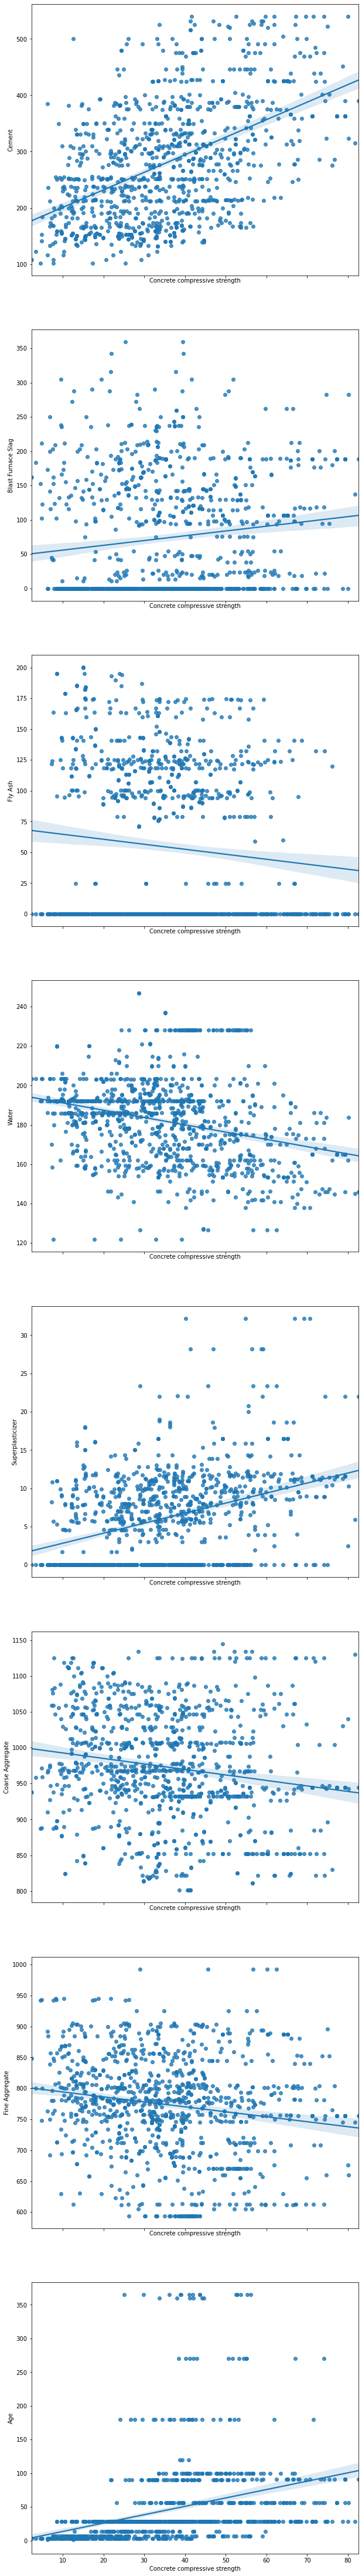

In [4]:
# Se consigue el hash de conversión de columnas usando expresiones regulares
parsedColsHash = dict(map(lambda x: [x, re.sub(r"\s*\((.*\s*)*\)\s*", "", x, 2)], df.columns))
# Se renombran las columnas
renamedDf = df.rename(columns=parsedColsHash)
# Se grafica la distribución de columnas
fig, ax = plt.subplots(len(renamedDf.columns) - 1, 1, sharex=True, figsize=(10,10*(len(renamedDf.columns) - 1)))
for i, col in enumerate(renamedDf.columns[0:-1]):
    sns.regplot(x='Concrete compressive strength', y=col, data=renamedDf, ax=ax[i])

Vemos que hay tendencias claras en algunas de las distribuciones de los atributos, asi como <code>age</code> y <code>cement</code>. No así otros atributos que presentan una varianza mayor como <code>Flay Ash</code> y <code>Coarse Aggregate</code>.

## Ejercicio 3: Modelo

<ul>
<li>En base al vector objetivo, decida el mejor modelo e importe con <code>pygam</code>. Condicional a
esto, importe las métricas de desempeño asociadas.</li>
<li>Genere conjuntos de entrenamiento y validación.</li>
<li>Genere un primer modelo sin implementar la función <code>gridsearch</code>. Reporte el hiper
parámetro <code>lam</code> así como las métricas de desempeño asociadas.</li>
<li>Genere un segundo modelo implementando <code>gridsearch</code> en lambda con un <code>logspace</code>
entre -3 y 3. Comente sobre el mejor hiper parámetro y sus métricas de desempeño.</li>
</ul>


In [5]:
# X será nuestro conjunto de atributos e y será nuestra variable objetivo
X_train_pre, X_test_pre, y_train, y_test = train_test_split(renamedDf.iloc[:, :-1], renamedDf['Concrete compressive strength'], test_size =.3, random_state = 19137)
# Ajustamos el estandarizador sobre el conjunto de entrenamiento (para que aprenda la media y desv. est.)
scaler = StandardScaler().fit(X_train_pre)
# Con el estandarizador ajustado sobre entrenamiento, transformamos el conjunto de entrenamiento con esta estandarizacion
X_train = pd.DataFrame(scaler.transform(X_train_pre), columns = X_train_pre.columns)
# Transformamos el conjunto de pruebas con el estandarizador ajustado sobre entrenamiento
X_test = pd.DataFrame(scaler.transform(X_test_pre), columns = X_test_pre.columns)

In [6]:
# Definimos una función para reportar las estadísticas del modelo
def getSummary(model, label):
    print("="*3 + 'Análisis de modelo {}'.format(label) + "="*3)
    print('Mean Squared Error: {}'.format(mean_squared_error( y_test, model.predict(X_test))))
    print('Median Absolute Error: {}'.format(median_absolute_error( y_test, model.predict(X_test))))
    print('R2 Score: {}'.format(r2_score( y_test, model.predict(X_test))))

In [7]:
# Definimos el modelo indicandole qué tipo de función debe tratar de ajustar a cada atributo/variable independiente en la matriz que le entregaremos: s(0) significa que se debe ajustar un término de tipo spline a la primera columna entregada
gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7), fit_intercept=True).fit(X_train, y_train)
gam.summary()
getSummary(gam, 'Default lambdas')

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     80.3393
Link Function:                     IdentityLink Log Likelihood:                                 -3023.7127
Number of Samples:                          721 AIC:                                             6210.1039
                                                AICc:                                            6231.0772
                                                GCV:                                                32.421
                                                Scale:                                             25.9908
                                                Pseudo R-Squared:                                   0.9159
Feature Function                  Lam

Vemos que el parametro lambda es de 0.6 para todos los parámetros

In [12]:
# definimos el rango de hiperparametros a evaluar
lams = np.logspace(-3, 3, 3)
# Necesitamos generar copias de esta lista de valores a evaluar para cada funcion f(X), que en nuestro caso serán splines
lams = [lams]* len(X_train.columns)

# Realizamos el proceso de búsqueda por gridsearch invocando al método del mismo nombre
gam.gridsearch(X_train, y_train, lam = lams)
# Con el método summary obtenemos una tabla con los resultados del ajuste del modelo para la mejor combinación de hiper parámetros
gam.summary()
getSummary(gam, 'Predefined lambdas')

100% (6561 of 6561) |####################| Elapsed Time: 0:06:05 Time:  0:06:05


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     78.4813
Link Function:                     IdentityLink Log Likelihood:                                 -2997.3162
Number of Samples:                          721 AIC:                                             6153.5951
                                                AICc:                                            6173.5687
                                                GCV:                                               31.0581
                                                Scale:                                             25.0389
                                                Pseudo R-Squared:                                   0.9188
Feature Function                  Lam

Vemos claramente el mejor modelo es en el que se hizo la búsqueda con los lambdas predefinidos. Esto pues bajaron los errores cuadráticos y amento en 1% el r2_score.

## Ejercicio 4: Dependencia Parcial
<ul>
<li>En base al mejor modelo, reporte el comportamiento de la dependencia parcial de cada
atributo.</li>
<li>Para ello, genere una función que tenga como argumento de entrada el modelo
estimado y devuelva una grilla con todos los gráficos de dependencia parcial.</li>
<li>Reporte brevemente sobre qué atributos están asociados a mayores y menores. niveles
de resistencia.</li>
</ul>

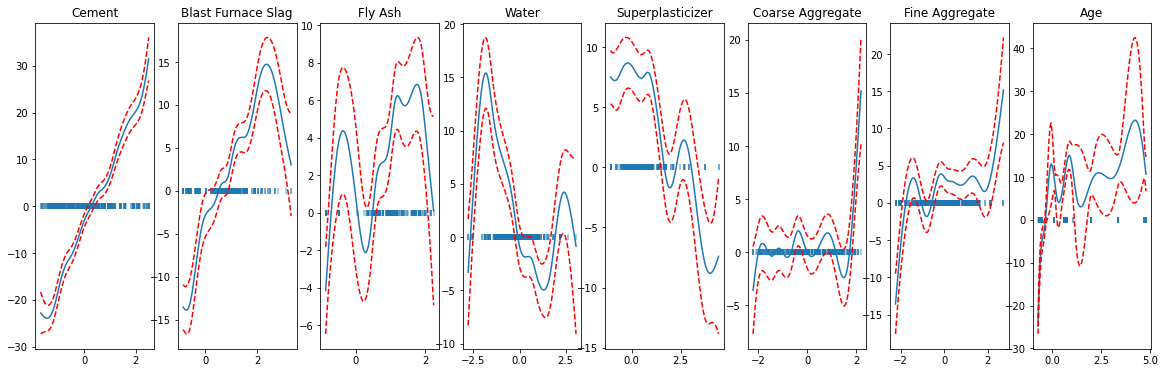

In [16]:
# Funcion para obtener graficos de dependencia parcial
def getPartialDependencies(model):
    fig, axs = plt.subplots(1,8, figsize = (20,6))
    titles = X_train.columns
    for i, ax in enumerate(axs.flatten()):
        XX = model.generate_X_grid(term=i)
        ax.plot(XX[:, i], model.partial_dependence(term=i, X=XX))
        ax.plot(XX[:, i], model.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
        ax.scatter(X_train[titles[i]], [0] * len(X_train[titles[i]]), marker = '|', alpha = .5)
        ax.set_title(titles[i])
getPartialDependencies(gam)

Vemos que hay atributos que se mantienen mas constantes que otros, asi como <code>Coarse Aggregate</code> y <code>Fine Aggregate</code> que presentan mas resistencia que otros atributos que oscilan mas como <code>Fly Ash</code> y <code>Water</code>.